## Extraction, Chunking and Embedding

In [1]:
# load txt from txt folder
import os

def load_txt(file_name):
    with open(file_name, 'r') as f:
        return f.read()

path="txt\Freud_Complete_en.txt"

if os.path.exists(path):
    print(load_txt(path)[:1000])    

<|file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/frcw452k.htm.md"|>
﻿

**Freud - Complete Works**

** **

**Ivan Smith 2000, 2007, 2010, 2011. All rights reserved.**

<|/file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/frcw452k.htm.md"|>
<|file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/TOC.htm.md"|>
﻿

**Table Of Contents**

**Chronological****   Alphabetical**

**Chronological**

 [Psychical (Or Mental) Treatment (1890a)](frcw3hro.htm)

 [On The Psychical Mechanism Of Hysterical Phenomena (1893a)](frcw9zn9.htm)

 [Charcot (1893f)](frcw9zlf.htm)

 [The Neuro-Psychoses Of Defence (1894a)](frcw9zp5.htm)

 [On The Grounds For Detaching A Particular Syndrome From Neurasthenia Under The Description 'Anxiety Neurosis' (1895b)](frcw02id.htm)

 [Obsessions And Phobias (1895c)](frcw02gl.htm)

 [Studies On Hysteria (1895d)](frcw48c2.htm)

 [A Reply To Criticisms Of My Paper On Anxiety Neurosis (1895f)](frcw02nk.htm)

 [Heredity And The Aetiology Of The Neuroses (1896a)](frcw02

In [2]:
from llama_index.core.node_parser import SentenceWindowNodeParser, SentenceSplitter
from llama_index.core import Document

sentence_splitter = SentenceSplitter().from_defaults(chunk_size=1000, chunk_overlap=200)
documents=[Document(text=load_txt(path), id='Freud_Complete_en')]

# Initialize node parser
node_parser = SentenceWindowNodeParser(window_size=5, sentence_splitter=sentence_splitter)
    
# Parse text with token splitter
chunks=node_parser.build_window_nodes_from_documents(documents)

In [6]:
len(chunks)

3328

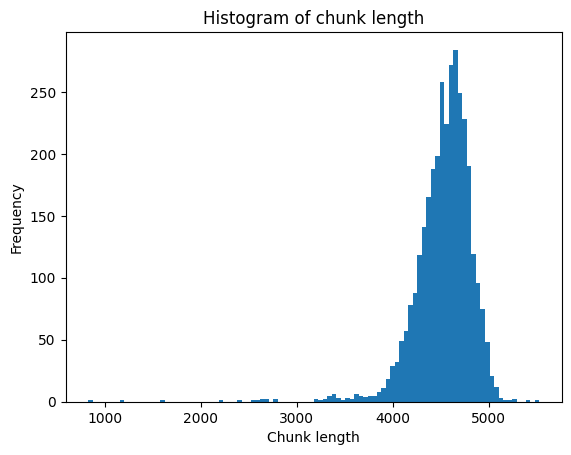

In [3]:
# describe chunk length
chunks_len=[len(chunk.text) for chunk in chunks]

import numpy as np
import matplotlib.pyplot as plt

plt.hist(chunks_len, bins=100)

plt.title('Histogram of chunk length')
plt.xlabel('Chunk length')
plt.ylabel('Frequency')
plt.show()

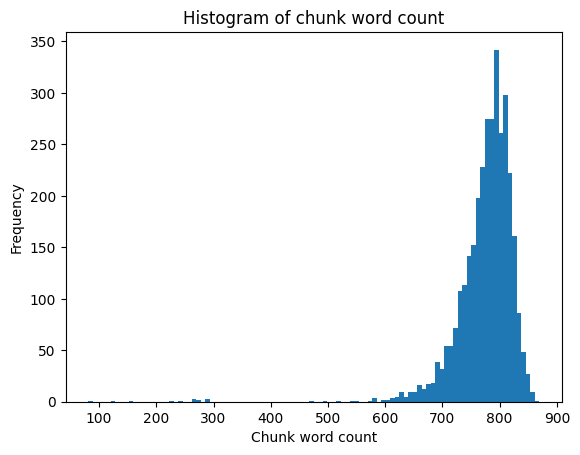

In [4]:
# same but word count
chunks_word_count=[len(chunk.text.split()) for chunk in chunks]

plt.hist(chunks_word_count, bins=100)

plt.title('Histogram of chunk word count')

plt.xlabel('Chunk word count')

plt.ylabel('Frequency')

plt.show()

In [5]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
from llama_index.core import StorageContext, load_index_from_storage

# Load the model
embed_model = HuggingFaceEmbedding(model_name="multi-qa-MiniLM-L6-cos-v1")
Settings.embed_model = embed_model
storage_context = StorageContext.from_defaults(persist_dir="freud_index")
index = load_index_from_storage(persist_dir="freud_index", storage_context=storage_context)
# index=VectorStoreIndex(nodes=chunks, show_progress=True)
index.storage_context.persist("freud_index")

C:\Users\rmlaz\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\rmlaz\AppData\Roaming\Python\Python39\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future 

In [7]:
for doc in index.docstore.docs.values():
    print(doc.text[:100])

<|file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/frcw452k.htm.md"|>
﻿

**Freud - Complete Wor
M. Furst) (1907c)](frcw3u28.htm)

 [Prospectus For Schriften Zur Angewandten Seelenkunde (1907e)](fr
htm)

 [Types Of Onset Of Neurosis (1912c)](frcw93w8.htm)

 [On The Universal Tendency To Debasement
htm)

 [Some Character-Types Met With In Psycho-Analytic Work (1916d)](frcw4ak8.htm)

 [Introductory
Sandor Ferenczi (On His 50th Birthday) (1923i)](frcw9zu9.htm)

 [Letter To Le Disque Vert (1924a)](f
Ernest Jones (On His 50th Birthday) (1929a)](frcw0fcp.htm)

 [Some Dreams Of Descartes' (1929b)](frc
(1933b)](frcw0iwn.htm)

 [Sandor Ferenczi (1933c)](frcw0lpu.htm)

 [Preface To Marie Bonaparte's The
Sigm. Freud 1877-1897 (1897b)](frcw05pw.htm)

 [Address Delivered In The Goethe House At Frankfurt (
Anton Von Freund (1920c)](frcw52pl.htm)

 [Dr. Ernest Jones (On His 50th Birthday) (1929a)](frcw0fcp
Alfons Paquet (1930d)](frcw0cj9.htm)

 [Letter To Dr. Friedrich S. Kraus On Anthropophyteia

## Retrieval

In [8]:
from llama_index.retrievers.bm25 import BM25Retriever

k=10

vector_retriever = index.as_retriever(similarity_top_k=k)

bm25_retriever = BM25Retriever.from_defaults(
    docstore=index.docstore, similarity_top_k=k
)

resource module not available on Windows


In [9]:
from llama_index.core.retrievers import QueryFusionRetriever

retriever = QueryFusionRetriever(
    [vector_retriever, bm25_retriever],
    similarity_top_k=10,
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=True,
    verbose=True,
)

In [ ]:
import nest_asyncio
from llama_index.core.response.notebook_utils import display_source_node

nest_asyncio.apply()

retrieved_nodes = retriever.retrieve("complesso di edipo")

for node in retrieved_nodes:
    display_source_node(node, source_length=500)

**Node ID:** 46906c64-8c4a-4069-9d50-1a87c577698f<br>**Similarity:** 0.016666666666666666<br>**Text:** Oedipus, son of Laius, King of Thebes, and of Jocasta, was exposed as an infant because an oracle had warned Laius that the still unborn child would be his father's murderer. The child was rescued, and grew up as a prince in an alien court, until, in doubts as to his origin, he too questioned the oracle and was warned to avoid his home since he was destined to murder his father and take his mother in marriage. On the road leading away from what he believed was his home, he met King Laius and ...<br>

**Node ID:** 074686d5-fcd4-460e-8328-9dc85149d548<br>**Similarity:** 0.016666666666666666<br>**Text:** Thus it is impossible to keep a check on it, to administer it in doses or to intensify it. Is it not then a justifiable endeavour on the part of a physician to seek to obtain command of this factor, to use it with a purpose, and to direct and strengthen it? This and nothing else is what scientific psychotherapy proposes.

* * *

On Psychotherapy

1565

   And, in the third place, Gentlemen, I would remind you of the well-established fact that certain diseases, in particular the psychoneuroses...<br>

**Node ID:** 54fe72a9-1c9a-46ea-84af-5fb820aab407<br>**Similarity:** 0.01639344262295082<br>**Text:** Moreover, we see the hero's Oedipus complex, as it were, in a reflected light, by learning the effect upon him of the other's crime. He ought to avenge the crime, but finds himself, strangely enough, incapable of doing so. We know that it is his sense of guilt that is paralysing him; but, in a manner entirely in keeping with neurotic processes, the sense of guilt is displaced on to the perception of his inadequacy for fulfilling his task. There are signs that the hero feels this guilt as a su...<br>

**Node ID:** 4b49f815-f668-4e82-8a76-a7cda51078e9<br>**Similarity:** 0.01639344262295082<br>**Text:** In an age which was beginning to replace the authority of the Church by that of antiquity and which was not yet familiar with any form of research not based on presuppositions, Leonardo - the forerunner and by no means unworthy rival of Bacon and Copernicus - was necessarily isolated. In his dissection of the dead bodies of horses and human beings, in his construction of flying machines, and in his studies on the nutrition of plants and their reactions to poisons, he certainly departed widely...<br>

**Node ID:** e4feef01-4bf1-482a-abe6-726e606921c9<br>**Similarity:** 0.016129032258064516<br>**Text:** (37) On another occasion the same professor said: 'In the case of the female genitals, in spite of many _Versuchungen_ [temptations] - I beg you pardon, _Versuche_ [experiments] . . .'

   ¹ [What she meant to say was: 'All right, then, when does this Dr. X. have his consulting hours?' She should have used the word '_ordiniert_ ' for 'has his consulting hours'. Instead she said '_ordin art_', which is a non-existent word. '_Ordin ar_', however, means 'common', 'vulgar'.]

* * *

The Psychopat...<br>

**Node ID:** d630c643-a84c-432a-b19c-43be7e9136cf<br>**Similarity:** 0.016129032258064516<br>**Text:** Painting, says Leonardo, works _per via di porre_ , for it applies a substance - particles of colour - where there was no thing before, on the colourless canvas; sculpture, however, proceeds _per via di levare_ , since it takes away from the block of stone all that hides the surface of the statue contained in it. In a similar way, the technique of suggestion aims at proceeding _per via di porre_ ; it is not concerned with the origin, strength and meaning of the morbid symptoms, but instead, i...<br>

**Node ID:** 1578f06e-eded-4925-8a4c-502898957cc0<br>**Similarity:** 0.015873015873015872<br>**Text:** The first of these scenes is the suitors' choice between the three caskets in _The Merchant of Venice_. The fair and wise Portia is bound at her father's bidding to take as her husband only that one of her suitors who chooses the right casket from among the three before him. The three caskets are of gold, silver and lead: the right casket is the one that contains her portrait. Two suitors have already departed unsuccessful: they have chosen gold and silver. Bassanio, the third, decides in fav...<br>

**Node ID:** 18998acb-5db5-4d72-8fba-ba61af379aad<br>**Similarity:** 0.015873015873015872<br>**Text:** Anyone who thinks of Leonardo's paintings will be reminded of a remarkable smile, at once fascinating and puzzling, which he conjured up on the lips of his female subjects. It is an unchanging smile, on long, curved lips; it has become a mark of his style and the name 'Leonardesque' has been chosen for it.¹ In the strangely beautiful face of the Florentine Mona Lisa del Giocondo it has produced the most powerful and confusing effect on whoever looks at it. This smile has called for an interpr...<br>

**Node ID:** e1cb264f-7c52-417a-af31-f5ca5490b643<br>**Similarity:** 0.015625<br>**Text:** ¹ I have to thank Dr. Otto Rank for calling my attention to these similarities.

* * *

The Theme Of The Three Caskets

2607

   It must strike us that this excellent third woman has in several instances certain peculiar qualities besides her beauty. They are qualities that seem to be tending towards some kind of unity; we must certainly not expect to find them equally well marked in every example. Cordelia makes herself unrecognizable, in conspicuous like lead, she remains dumb, she 'loves a...<br>

**Node ID:** 820f5b56-117e-4ecc-9a55-6ec04e686c0f<br>**Similarity:** 0.015625<br>**Text:** She suffered the humiliation of having the title of a play based on Jules Verne's well-known novel used as an allusion to her misshapen figure: 'Round the Wilt in 80 Days'.²

   Or: 'Every fathom a queen', a modification of Shakespeare's familiar 'Every inch a king'. The allusion to this quotation was made with reference to an aristocratic and over-life-size lady. No very serious objection could really be made if anyone were to prefer to include this joke among the 'condensations accompanied ...<br>

In [15]:
nodes_pure_vector = vector_retriever.retrieve("oedipus complex")

for node in nodes_pure_vector:
    display_source_node(node, source_length=500)

**Node ID:** e3eed82f-6faf-4c4a-9ca9-55e947cd28b6<br>**Similarity:** 0.5064101615734631<br>**Text:** Its infantile core and more or less of its accessories remain as they were confirmed by the direct observation of children.

* * *

Introductory Lectures On Psycho-Analysis

3402

   The clinical fact which meets us behind the form of the Oedipus complex as it is established by analysis is of the highest practical significance. We learn that at puberty, when the sexual instinct first makes its demands in full strength, the old familiar incestuous objects are taken up again and freshly cathect...<br>

**Node ID:** 496802aa-e91b-4970-a0cf-aa2f260b0812<br>**Similarity:** 0.4751856966913716<br>**Text:** Every evening there after the medical officers of the corps, his colleagues and his superiors, came together in order to learn the secret doctrines of analysis. All went well for a while; but when he spoke to his audience about the Oedipus complex, one of his superiors rose, declared he did not believe it, that it was a vile act on the part of the lecturer to speak of such things to them, honest men who were fighting for their country and fathers of a family, and that he forbade the continuan...<br>

**Node ID:** 481c0901-6af3-429a-b8c8-ae64f9e5c7b4<br>**Similarity:** 0.46190616020592207<br>**Text:** <|/file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/frcw0fcp.htm.md"|>
<|file name="./epubs\\Freud_Complete_en.epub/OEBPS/html/frcw0fe8.htm.md"|>
﻿

* * *

4610

THE EXPERT OPINION IN THE HALSMANN CASE

(1931)

The Oedipus complex, as far as we know, is present in childhood in all human beings, undergoes great alterations during the years of development and in many individuals is found in varying degrees of strength even at a mature age. Its essential characteristics, its universality, i...<br>

**Node ID:** cb0016a8-8758-4be7-bace-90d473c56030<br>**Similarity:** 0.4611551575984697<br>**Text:** Although the majority of human beings go through the Oedipus complex as an individual experience, it is nevertheless a phenomenon which is determined and laid down by heredity and which is bound to pass away according to programme when the next pre-ordained phase of development sets in. This being so, it is of no great importance what the occasions are which allow this to happen, or, indeed, whether any such occasions can be discovered at all.

* * *

The Dissolution Of The Oedipus Complex

4...<br>

**Node ID:** b44a6197-8ae2-4c29-9da3-ac2b73a169f8<br>**Similarity:** 0.4533112825441857<br>**Text:** In her, far more than in the boy, these changes seem to be the result of upbringing and of intimidation from outside which threatens her with a loss of love. The girl's Oedipus complex is much simpler than that of the small bearer of the penis; in my experience, it seldom goes beyond the taking of her mother's place and the adopting of a feminine attitude towards her father. Renunciation of the penis is not tolerated by the girl without some attempt at compensation. She slips - along the line...<br>

**Node ID:** 1990e3de-8ba7-4367-bf9e-2afc47c28614<br>**Similarity:** 0.4505788315680092<br>**Text:** But we come upon this dream-wish, too, where it has no relevance in real life, and where the adult need never confess to it in his waking life. The reason for this is that the deepest and most invariable motive for estrangement, especially between two people of the same sex, has already made itself felt in early childhood.

   What I have in mind is rivalry in love, with a clear emphasis on the subject's sex. While he is still a small child, a son will already begin to develop a special affec...<br>

**Node ID:** 6f4a1361-9588-4d8d-b510-345ac495a4ff<br>**Similarity:** 0.4350676765429264<br>**Text:** This being so, the pre-Oedipus phase in women gains an importance which we have not attributed to it hitherto.

* * *

Female Sexuality

4591

   Since this phase allows room for all the fixations and repressions from which we trace the origin of the neuroses, it would seem as though we must retract the universality of the thesis that the Oedipus complex is the nucleus of the neuroses. But if anyone feels reluctant about making this correction, there is no need for him to do so. On the one ha...<br>

**Node ID:** 078d3783-22ff-4d02-9fe6-e5ba30784523<br>**Similarity:** 0.42193183154729297<br>**Text:** And he understands the dramatist's voice as though it were saying to him: 'You are struggling in vain against your responsibility and are protesting in vain of what you have done in opposition to these criminal intentions. You are guilty, for you have not been able to destroy them; they still persist in you unconsciously.' And there is psychological truth contained in this. Even if a man has repressed his evil impulses into the unconscious and would like to tell himself afterwards that he is ...<br>

**Node ID:** c5d1462e-8ade-4ca6-8e66-9c0bf89bb1ab<br>**Similarity:** 0.4148715977081857<br>**Text:** But, more fortunate than he, we have meanwhile succeeded, in so far as we have not become psychoneurotics, in detaching our sexual impulses from our mothers and in forgetting our jealousy of our fathers. Here is one in whom these primaeval wishes of our childhood have been fulfilled, and we shrink back from him with the whole force of the repression by which those wishes have since that time been held down within us. While the poet, as he unravels the past, brings to light the guilt of Oedipu...<br>

**Node ID:** 1080a0a1-b119-4960-9026-19bb7fd3282a<br>**Similarity:** 0.4137316295167258<br>**Text:** This contradiction is cleared up if we reflect that the castration complex always operates in the sense implied in its subject-matter: it inhibits and limits masculinity and encourages femininity. The difference between the sexual development of males and females at the stage we have been considering is an intelligible consequence of the anatomical distinction between their genitals and of the psychical situation involved in it; it corresponds to the difference between a castration that has b...<br>

In [16]:
# pure bm25
nodes_pure_bm25 = bm25_retriever.retrieve("oedipus complex")

for node in nodes_pure_bm25:
    display_source_node(node, source_length=500)

**Node ID:** 593f7cf7-9d35-4b8c-a80e-64dc27a23fdc<br>**Similarity:** 4.27217435836792<br>**Text:** This process ushers in the latency period, which now interrupts the child's sexual development.

* * *

The Dissolution Of The Oedipus Complex

4089

   I see no reason for denying the name of a 'repression' to the ego's turning away from the Oedipus complex, although later repressions come about for the most part with the participation of the super-ego, which in this case is only just being formed. But the process we have described is more than a repression. It is equivalent, if it is ideall...<br>

**Node ID:** 79b1a726-6b59-4394-a74e-efb2c8d8a38d<br>**Similarity:** 4.260096073150635<br>**Text:** It is this complicating element introduced by bisexuality that makes it so difficult to obtain a clear view of the facts in connection with the earliest object-choices and identifications, and still more difficult to describe them intelligibly. It may even be that the ambivalence displayed in the relations to the parents should be attributed entirely to bisexuality and that it is not, as I have represented above, developed out of identification in consequence of rivalry.

   In my opinion it ...<br>

**Node ID:** b4967786-f979-4697-82b1-20c8eb245564<br>**Similarity:** 4.25386381149292<br>**Text:** The perversion is no longer an isolated fact in the child's sexual life, but falls into its place among the typical, not to say normal, processes of development which are familiar to us. It is brought into relation with the child's incestuous love-object, with its Oedipus complex. It first comes into prominence in the sphere of this complex, and after the complex has broken down it remains over, often quite by itself, the inheritor of the charge of libido from that complex and weighed down by...<br>

**Node ID:** 27c89dca-41fd-40f7-825c-5867c4994907<br>**Similarity:** 4.243925094604492<br>**Text:** But there is no evidence to show that, when the threat of castration takes place, those experiences have any effect. It is not until a _fresh_ experience comes his way that the child begins to reckon with the possibility of being castrated, and then only hesitatingly and unwillingly, and not without making efforts to depreciate the significance of something he has himself observed.

   The observation which finally breaks down his unbelief is the sight of the female genitals. Sooner or later ...<br>

**Node ID:** 3565880e-b1e1-4792-b214-c1b36cc22737<br>**Similarity:** 4.230148792266846<br>**Text:** Many years later, when her masturbatory activity has long since been suppressed, an interest still persists which we must interpret as a defence against a temptation that is still dreaded. It manifests itself in the emergence of sympathy for those to whom similar difficulties are attributed, it plays a part as a motive in contracting a marriage and, indeed, it may determine the choice of a husband or lover. Disposing of early infantile masturbation is truly no easy or indifferent business.

*...<br>

**Node ID:** 44e8fbe1-5b43-4576-9cdf-18e924de9dc2<br>**Similarity:** 4.215171813964844<br>**Text:** For a time these two relationships proceed side by side, until the boy's sexual wishes in regard to his mother become more intense and his father is perceived as an obstacle to them; from this the Oedipus complex originates.² His identification with his father then takes on a hostile colouring and changes into a wish to get rid of his father in order to take his place with his mother. Henceforward his relation to his father is ambivalent; it seems as if the ambivalence inherent in the identif...<br>

**Node ID:** 1990e3de-8ba7-4367-bf9e-2afc47c28614<br>**Similarity:** 4.157995223999023<br>**Text:** But we come upon this dream-wish, too, where it has no relevance in real life, and where the adult need never confess to it in his waking life. The reason for this is that the deepest and most invariable motive for estrangement, especially between two people of the same sex, has already made itself felt in early childhood.

   What I have in mind is rivalry in love, with a clear emphasis on the subject's sex. While he is still a small child, a son will already begin to develop a special affec...<br>

**Node ID:** 0d527a55-b3f1-4f73-94ba-87bfa2cc860e<br>**Similarity:** 4.121237754821777<br>**Text:** Moreover, I was the only worker in a new field, so that my reticence involved no danger to myself and no loss to others.

* * *

Some Psychical Consequences Of The Anatomical Distinction Between The Sexes

4147

   But now everything has changed. The time before me is limited. The whole of it is no longer spent in working, so that my opportunities for making fresh observations are not so numerous. If I think I see something new, I am uncertain whether I can wait for it to be confirmed. And fu...<br>

**Node ID:** e9c1b54d-5dbb-4c21-bbe0-a1ffd6ee55e2<br>**Similarity:** 4.08647346496582<br>**Text:** The threat of castration compels him, however, to give up that attitude. Under the impression of the danger of losing his penis, the Oedipus complex is abandoned, repressed and, in the most normal cases, entirely destroyed, and a severe super-ego is set up as its heir. What happens with a girl is almost the opposite. The castration complex prepares for the Oedipus complex instead of destroying it; the girl is driven out of her attachment to her mother through the influence of her envy for the...<br>

**Node ID:** 1de5d96e-0f4f-485a-b76e-5cd1ab9c4807<br>**Similarity:** 4.0611467361450195<br>**Text:** The phenomena of conscience, however, lead us to infer that the destructiveness which returns from the external world is also taken up by the super-ego, without any such transformation, and increases its sadism against the ego. The sadism of the super-ego and the masochism of the ego supplement each other and unite to produce the same effects. It is only in this way, I think, that we can understand how the suppression of an instinct can - frequently or quite generally - result in a sense of g...<br>